In [1]:
##################################
### Import the usual libraries ###
##################################

#numpy
import numpy as np

# scipy
from scipy.stats import binned_statistic

#astropy
import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column, QTable

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.offsetbox import AnchoredText

# Yumi's Code to convert (RA,DEC) to MS coordinates
import MagellanicStream as ms

# .py files for grad calc
import astrofunctions as astro
import lmcgeometry as lgeo
import mlefitting as mle
import utilities as util

# Ignore warnings unless crashes
import warnings
warnings.filterwarnings('ignore')

#progress bars
from tqdm import tqdm_notebook

In [2]:
# PARSEC Isochrones
parsecall = ascii.read('/Users/joshuapovick/Desktop/Research/parsec/parsec3_3.dat',format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

# LMC lmc data
lmc = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.r13-l33-58672.fits.gz',1)
cln = np.where((lmc['FE_H']>-9999.0)&(lmc['AK_TARG']>-9999.0)&(lmc['LOGG']>0.0)&
                (lmc['M_H_ERR']>-90.0)&(lmc['C_FE']>-9999.0)&(lmc['N_FE']>-9999.0))

lmc = lmc[cln]

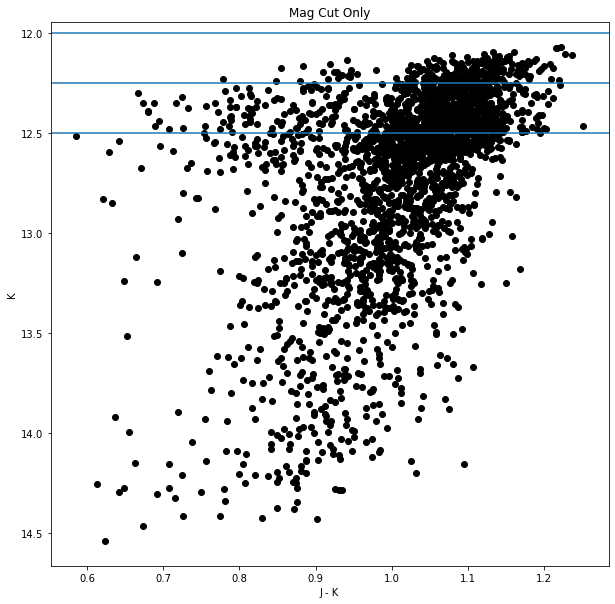

In [3]:
plt.figure(figsize=[10,10])
plt.scatter((lmc['J']-lmc['K']),lmc['K'],c='k')
plt.axhline(12.0)
plt.axhline(12.25)
plt.axhline(12.5)

plt.gca().invert_yaxis()

plt.xlabel(r'J - K')
plt.ylabel(r'K')
plt.title(r'Mag Cut Only')

plt.show()

In [4]:
### AGB Cut
left = parsec[np.where(parsec['MH']==min(parsec['MH']))]
middle = parsec[np.where(parsec['MH']==-1.115)]
right = parsec[np.where(parsec['MH']==max(parsec['MH']))]

gravs = [min(left['logg'])-0.03,min(middle['logg']),min(right['logg'])-0.015]

teffs = [max(10**left[np.where(left['logg']==min(left['logg']))]['logTe']),
         min(10**middle[np.where(middle['logg']==min(middle['logg']))]['logTe']),
         min(10**right[np.where(right['logg']==min(right['logg']))]['logTe'])]

zagb = np.polyfit(teffs, gravs, 3)
pagb = np.poly1d(zagb)

agb_cut = np.where(lmc['LOGG']>pagb(lmc['TEFF']))

### Bloop Cut
kmags = [0.7,1.]
colos = [13.5,12.]

zbloop = np.polyfit(kmags, colos, 1)
pbloop = np.poly1d(zbloop)

bloop_cut = np.where(lmc[agb_cut]['K']>pbloop(lmc[agb_cut]['J']-lmc[agb_cut]['K'])+0.1)

lmc_nobloop_noagb = lmc[agb_cut][bloop_cut]

In [5]:
# plt.figure(figsize=[10,10])
# plt.scatter((lmc['J']-lmc['K']),lmc['K'],c='k')
# plt.scatter((lmc['J']-lmc['K'])[agb_cut],lmc['K'][agb_cut],c='r',alpha=0.5)
# # plt.axhline(12.5,c='k')

# plt.gca().invert_yaxis()

# plt.xlabel(r'J - K')
# plt.ylabel(r'K')
# plt.title(r'AGB Cut')

# plt.show()

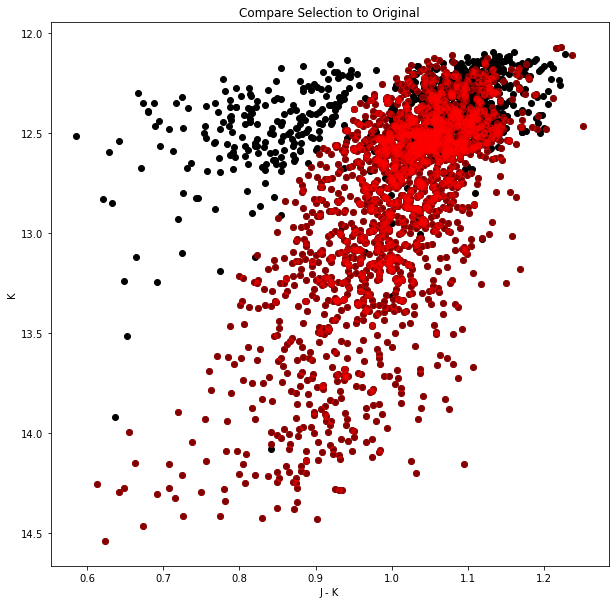

In [6]:
plt.figure(figsize=[10,10])
plt.scatter((lmc['J']-lmc['K']),lmc['K'],c='k')
plt.scatter((lmc_nobloop_noagb['J']-lmc_nobloop_noagb['K']),lmc_nobloop_noagb['K'],c='r',alpha=0.5)

plt.gca().invert_yaxis()

plt.xlabel(r'J - K')
plt.ylabel(r'K')
plt.title(r'Compare Selection to Original')

plt.show()

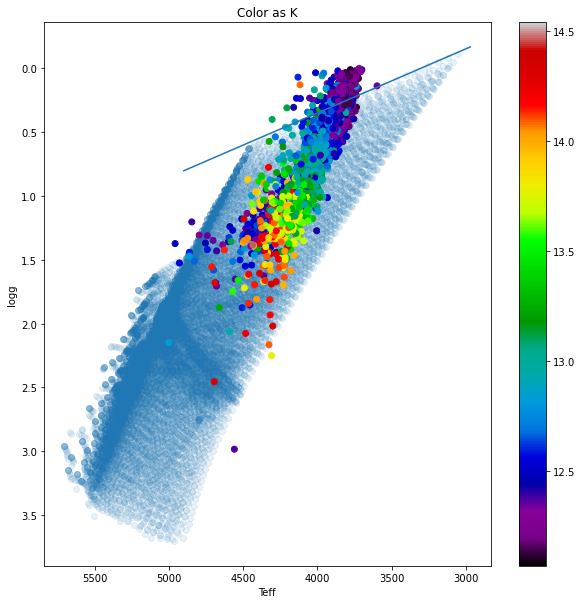

In [7]:
plt.figure(figsize=[10,10])
plt.scatter(10**parsec['logTe'],parsec['logg'],alpha=0.1)#,c=parsec['MH'])
# plt.colorbar()
# plt.scatter(10**parsecall[agb]['logTe'],parsecall['logg'][agb],c=parsecall['MH'][agb])
plt.scatter(lmc['TEFF'],lmc['logg'],c=lmc['K'],vmin=min(lmc['K']),cmap='nipy_spectral')
plt.colorbar()

plt.plot([2970,4900],[pagb(2970),pagb(4900)])
# plt.axhline(12.5,c='k')

plt.title(r'Color as K')
plt.xlabel(r'Teff')
plt.ylabel(r'logg')

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

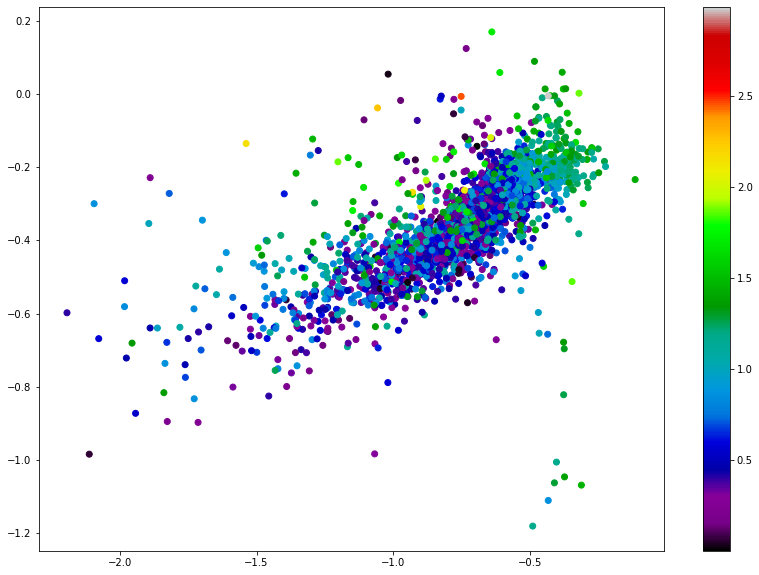

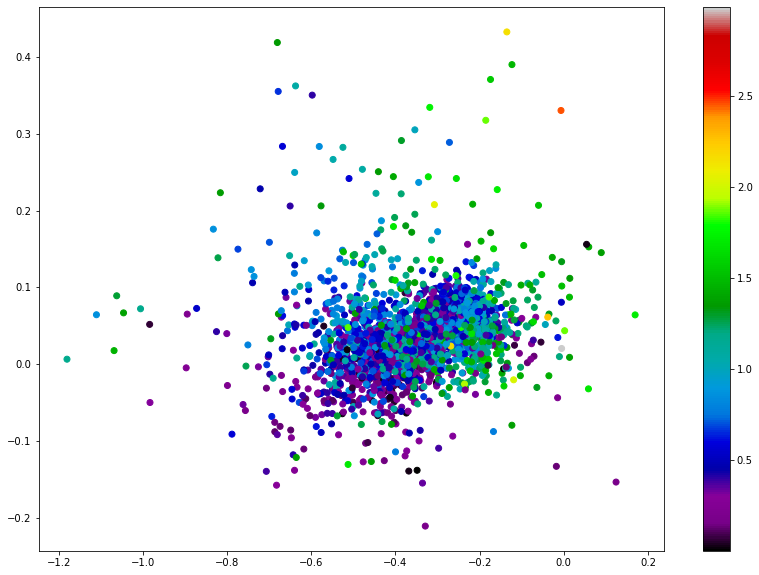

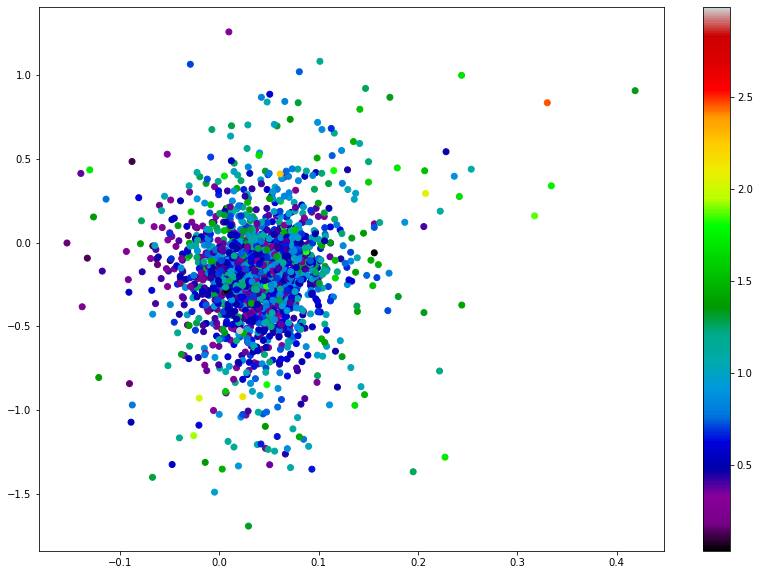

In [8]:
plt.figure(figsize=[14,10])
plt.scatter(lmc['FE_H'],lmc['C_FE'],c=lmc['LOGG'],cmap='nipy_spectral')
plt.colorbar()

plt.figure(figsize=[14,10])
plt.scatter(lmc['C_FE'],lmc['O_FE'],c=lmc['LOGG'],cmap='nipy_spectral')
plt.colorbar()

plt.figure(figsize=[14,10])
cln = np.where(lmc['NA_FE']>-100.)
plt.scatter(lmc['O_FE'][cln],lmc['NA_FE'][cln],c=lmc['LOGG'][cln],cmap='nipy_spectral')
plt.colorbar()

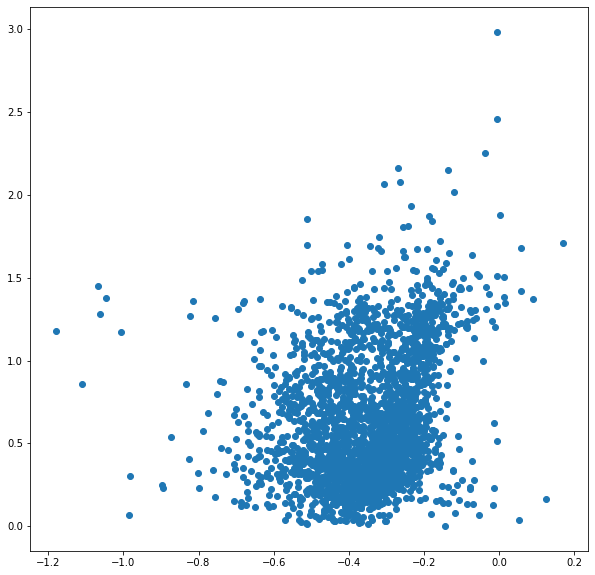

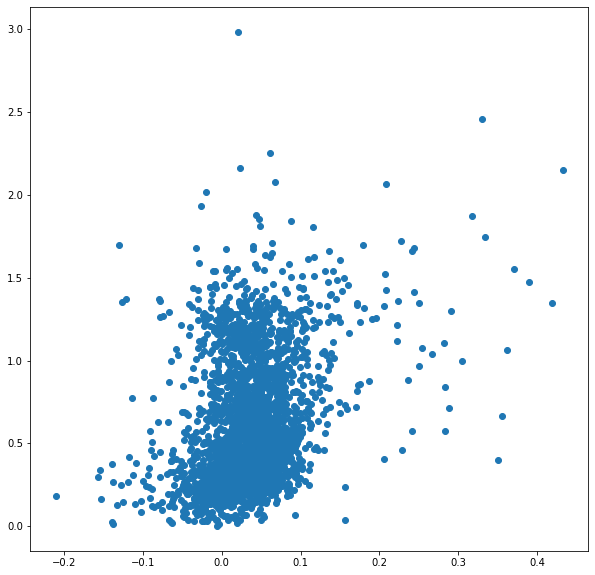

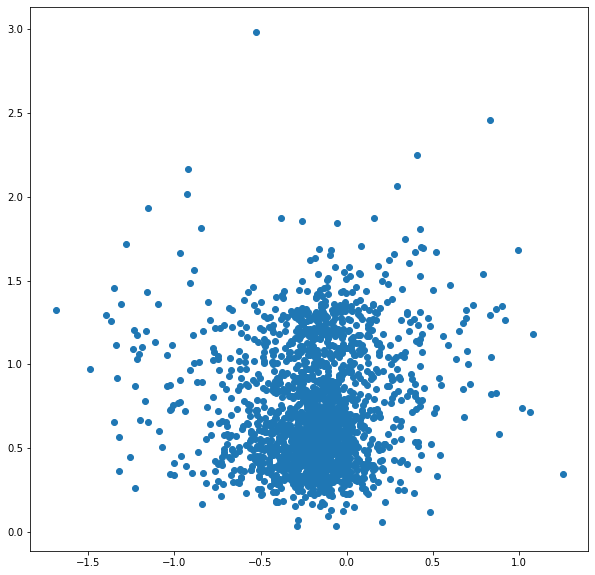

In [9]:
plt.figure(figsize=[10,10])
plt.scatter(lmc['C_FE'],lmc['LOGG'])
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(lmc['O_FE'],lmc['LOGG'])
plt.show()

plt.figure(figsize=[10,10])
cln = np.where(lmc['NA_FE']>-100.)
plt.scatter(lmc['NA_FE'][cln],lmc['LOGG'][cln])
plt.show()

In [10]:
print('mag cut',len(np.squeeze(np.where(lmc['K']>12.25)))/len(lmc))
print('logg cut',len(np.squeeze(np.where(lmc['LOGG']>0.25)))/len(lmc))
print('mag and logg',len(np.squeeze(np.where((lmc['K']>12.25)&(lmc['LOGG']>0.25))))/len(lmc))

mag cut 0.9126738794435858
logg cut 0.8489180834621329
mag and logg 0.8071870170015456


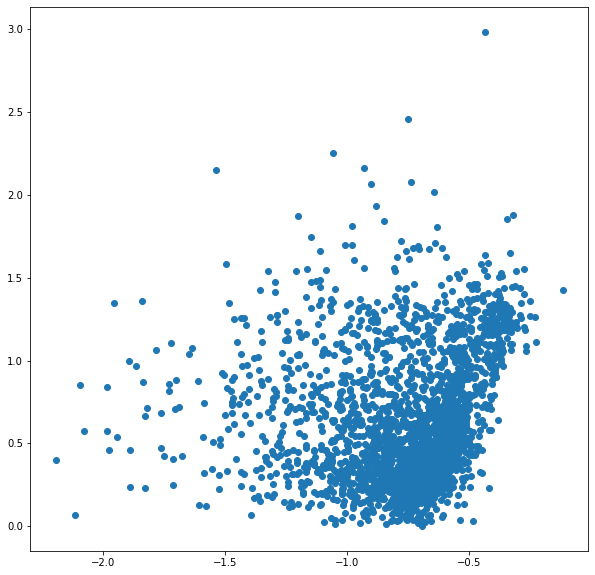

In [11]:
plt.figure(figsize=[10,10])
plt.scatter(lmc['FE_H'],lmc['LOGG'])

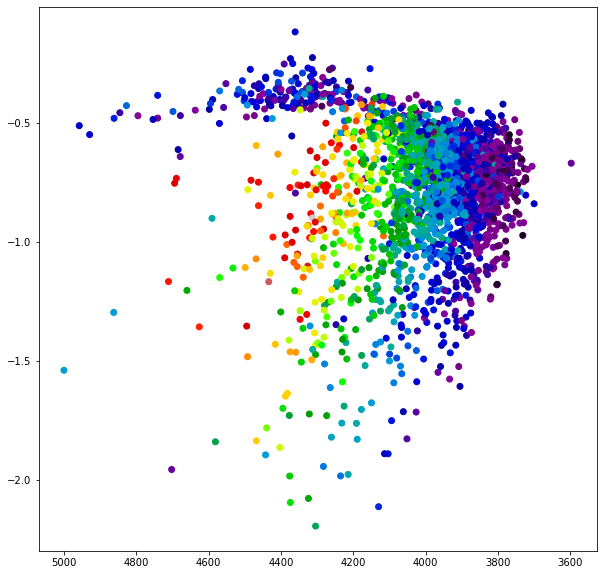

In [12]:
plt.figure(figsize=[10,10])
plt.scatter(lmc['TEFF'],lmc['FE_H'],c=lmc['K'],cmap='nipy_spectral')
plt.gca().invert_xaxis()

Text(0, 0.5, '[Fe/H]')

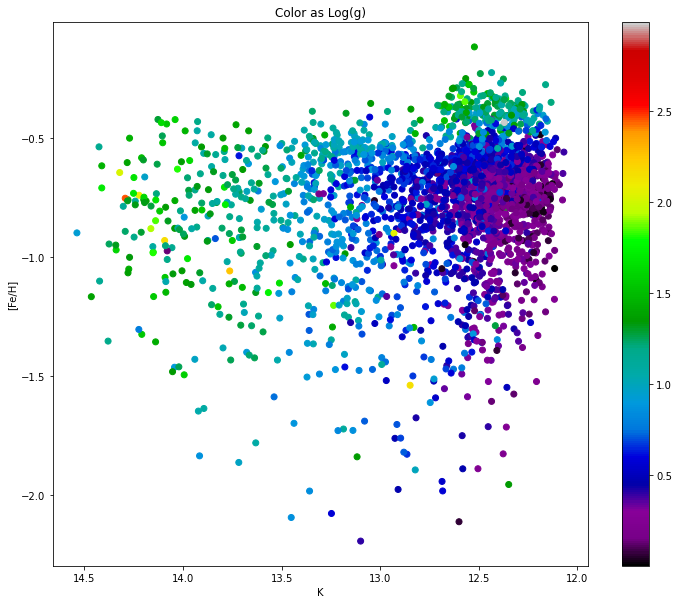

In [13]:
plt.figure(figsize=[12,10])
plt.scatter(lmc['K'],lmc['FE_H'],c=lmc['LOGG'],cmap='nipy_spectral')
plt.colorbar()
plt.gca().invert_xaxis()

plt.title(r'Color as Log(g)')
plt.xlabel(r'K')
plt.ylabel(r'[Fe/H]')

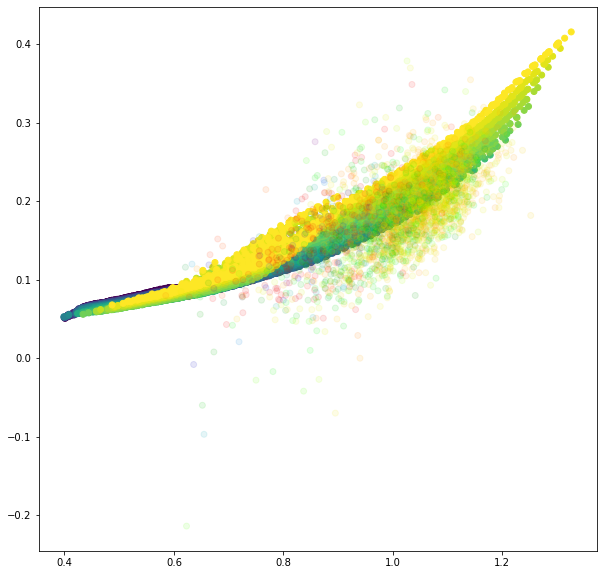

In [14]:
plt.figure(figsize=[10,10])
plt.scatter(parsec['Jmag']-parsec['Ksmag'],parsec['Hmag']-parsec['Ksmag'],c=parsec['MH'])
plt.scatter(lmc['J']-lmc['K'],lmc['H']-lmc['K'],c=lmc['FE_H'],cmap='nipy_spectral',alpha=0.1)


In [15]:
print(max(parsec['logg']))
print(min(parsec['logg']))

3.705
-0.11


In [16]:
print(max(lmc['logg']))
print(min(lmc['logg']))

2.984853
3.5826117e-05


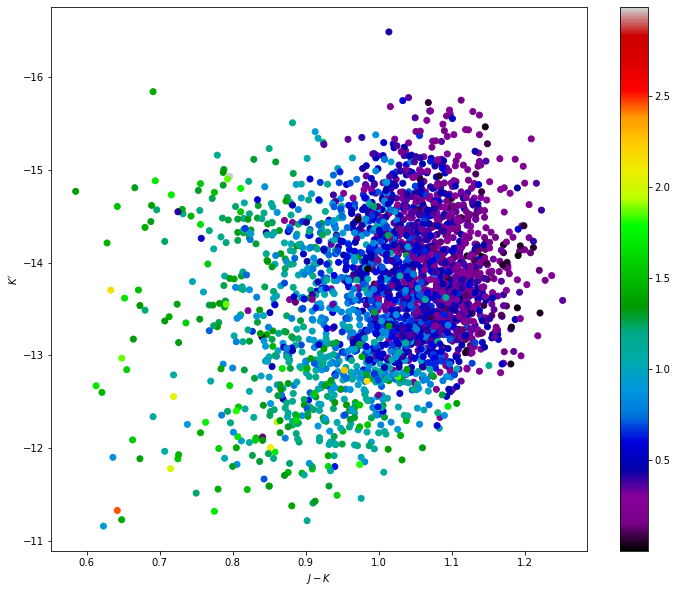

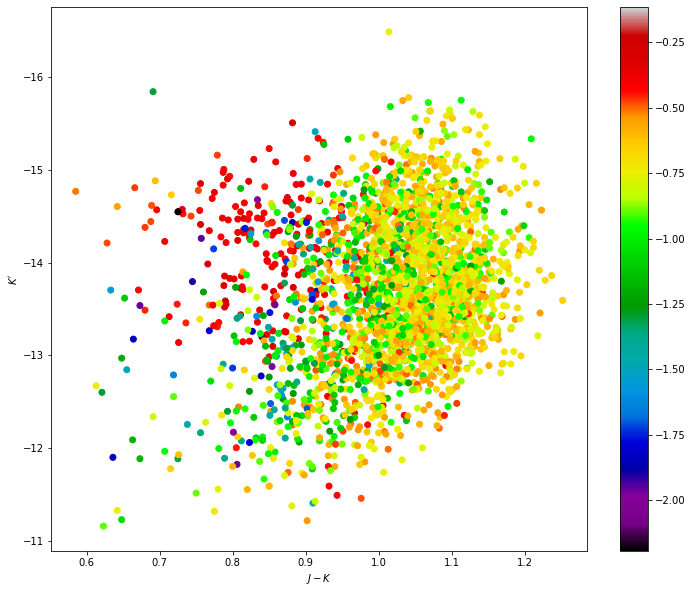

In [17]:
kprime = lmc['K']+5.*np.log(np.sqrt(lmc['GAIA_PMRA']**2+lmc['GAIA_PMDEC']**2)/1000.)+5

plt.figure(figsize=[12,10])
plt.scatter((lmc['J']-lmc['K']),kprime,c=lmc['logg'],cmap='nipy_spectral')
plt.colorbar()
# plt.scatter((lmc_nobloop_noagb['J']-lmc_nobloop_noagb['K']),lmc_nobloop_noagb['K'],c='r',alpha=0.5)

plt.gca().invert_yaxis()

plt.xlabel(r'$J - K$')
plt.ylabel(r'$K^\prime$')

plt.show()

plt.figure(figsize=[12,10])
plt.scatter((lmc['J']-lmc['K']),kprime,c=lmc['FE_H'],cmap='nipy_spectral')
plt.colorbar()
# plt.scatter((lmc_nobloop_noagb['J']-lmc_nobloop_noagb['K']),lmc_nobloop_noagb['K'],c='r',alpha=0.5)

plt.gca().invert_yaxis()

plt.xlabel(r'$J - K$')
plt.ylabel(r'$K^\prime$')

plt.show()

In [18]:
# plt.scat

AttributeError: module 'matplotlib.pyplot' has no attribute 'scat'

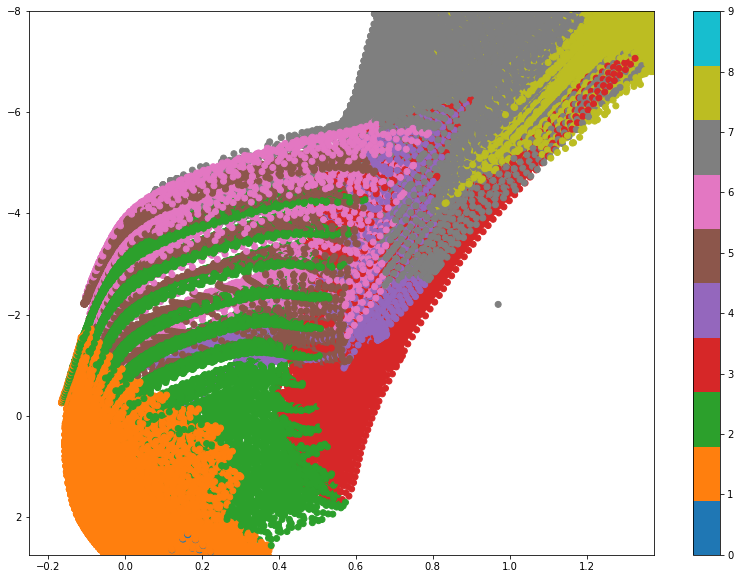

In [19]:
plt.figure(figsize=[14,10])
plt.scatter(parsecall['Jmag']-parsecall['Ksmag'],parsecall['Ksmag'],c=parsecall['label'],cmap='tab10')
plt.colorbar()
plt.xlim(-.25,1.375)
plt.ylim(-8,2.75)

plt.gca().invert_yaxis()



In [20]:
### AGB Cut
# left = parsec[np.where(parsec['MH']==min(parsec['MH']))]
# middle = parsec[np.where(parsec['MH']==-1.115)]
# right = parsec[np.where(parsec['MH']==max(parsec['MH']))]

# gravs = [min(left['logg'])-0.03,min(middle['logg']),min(right['logg'])-0.015]

# teffs = [max(10**left[np.where(left['logg']==min(left['logg']))]['logTe']),
#          min(10**middle[np.where(middle['logg']==min(middle['logg']))]['logTe']),
#          min(10**right[np.where(right['logg']==min(right['logg']))]['logTe'])]

# zagb = np.polyfit(teffs, gravs, 3)
# pagb = np.poly1d(zagb)

agb_cut = np.where((lmc['LOGG']>0.25)&(lmc['K']>12.25))

### Bloop Cut
kmags = [0.7,1.]
colos = [13.5,12.]

zbloop = np.polyfit(kmags, colos, 1)
pbloop = np.poly1d(zbloop)

bloop_cut = np.where(lmc[agb_cut]['K']>pbloop(lmc[agb_cut]['J']-lmc[agb_cut]['K'])+0.1)

lmc_nobloop_noagb = lmc[agb_cut][bloop_cut]

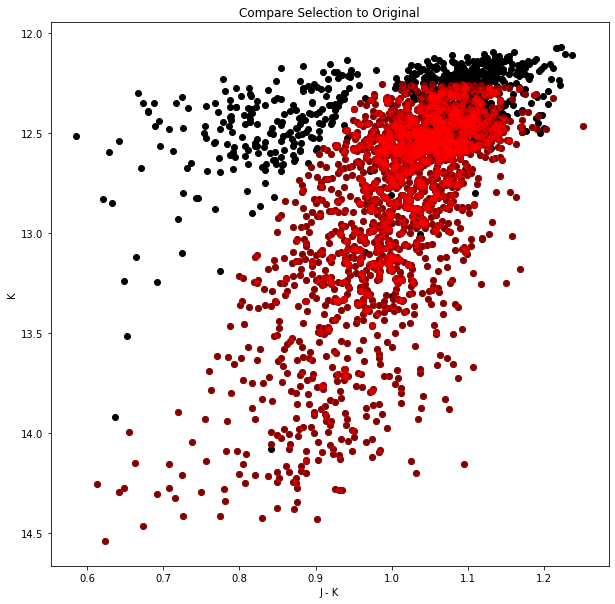

In [21]:
plt.figure(figsize=[10,10])
plt.scatter((lmc['J']-lmc['K']),lmc['K'],c='k')
plt.scatter((lmc_nobloop_noagb['J']-lmc_nobloop_noagb['K']),lmc_nobloop_noagb['K'],c='r',alpha=0.5)

plt.gca().invert_yaxis()

plt.xlabel(r'J - K')
plt.ylabel(r'K')
plt.title(r'Compare Selection to Original')

plt.show()

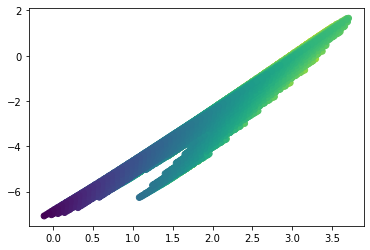

In [22]:
plt.scatter(parsec['logg'],parsec['Ksmag'],c=10**parsec['logTe'])

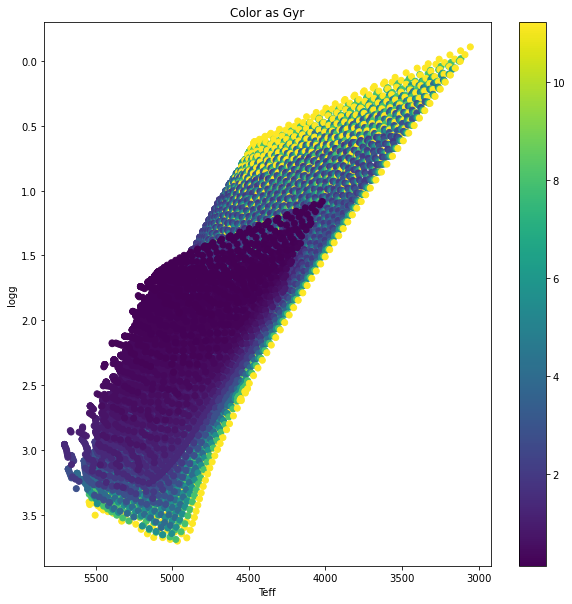

In [23]:
plt.figure(figsize=[10,10])
plt.scatter(10**parsec['logTe'],parsec['logg'],c=10**parsec['logAge']/10**9)
plt.colorbar()

plt.title(r'Color as Gyr')
plt.xlabel(r'Teff')
plt.ylabel(r'logg')

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

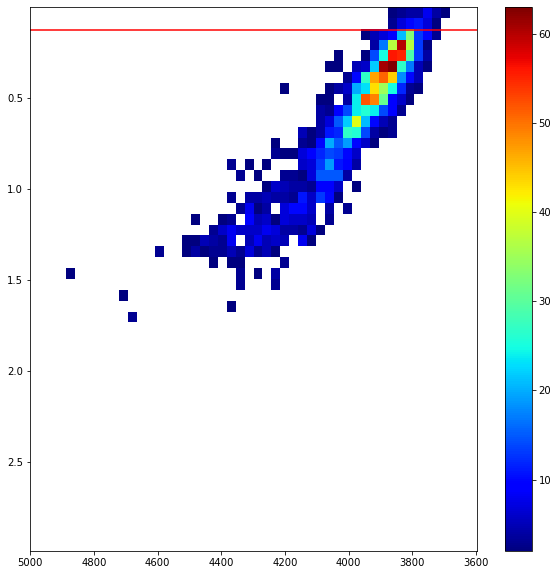

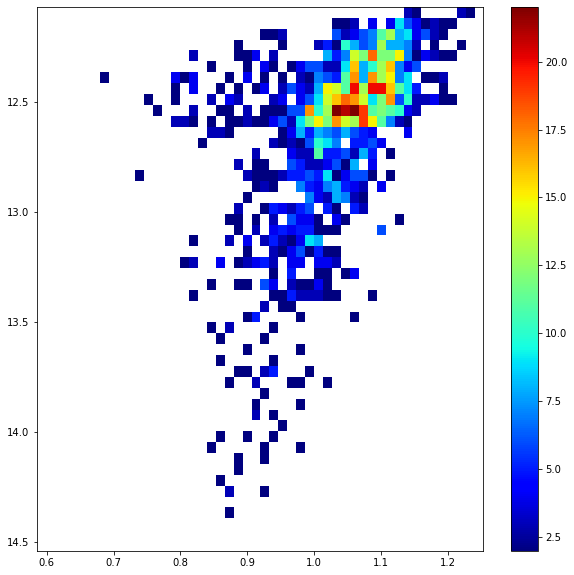

In [28]:
from scipy.stats import binned_statistic_2d
### HR 
N = binned_statistic_2d(lmc['TEFF'], lmc['LOGG'], None, 'count', bins=50,expand_binnumbers=True)
plt.figure(figsize=[10,10])
N.statistic[N.statistic<2.] = np.nan
plt.imshow(N.statistic.T, origin='lower',extent=[N.x_edge[0],N.x_edge[-1],N.y_edge[0],N.y_edge[-1]],
           aspect='auto',interpolation='nearest', cmap='jet')
plt.colorbar()

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.axhline(0.125,c='r')

plt.show()


### CMD
N = binned_statistic_2d(lmc['J']-lmc['K'], lmc['K'], None, 'count', bins=50,expand_binnumbers=True)
plt.figure(figsize=[10,10])
N.statistic[N.statistic<2.] = np.nan
plt.imshow(N.statistic.T, origin='lower',extent=[N.x_edge[0],N.x_edge[-1],N.y_edge[0],N.y_edge[-1]],
           aspect='auto',interpolation='nearest', cmap='jet')
plt.colorbar()

plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()

# plt.axhline(0.125,c='r')

plt.show()


In [29]:
pwd

'/Users/joshuapovick/Desktop/Research/LMC_Gradients/MCMC_LMC_Gradients'

Text(0, 0.5, '[C/M]')

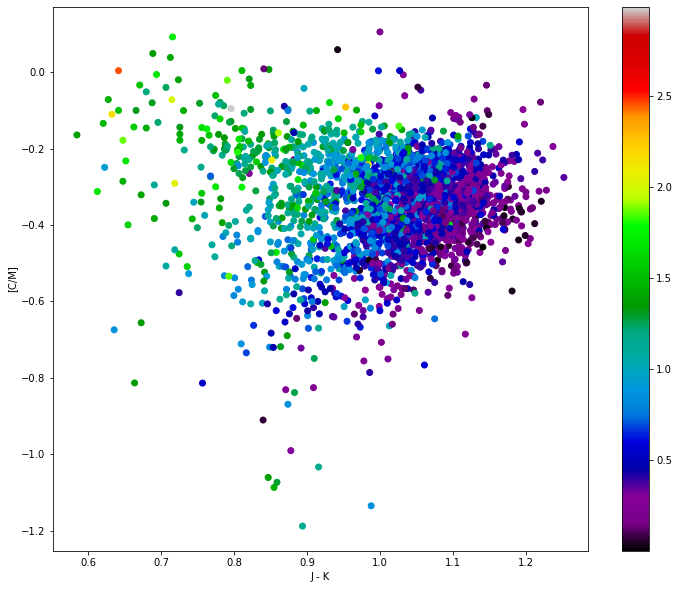

In [30]:
plt.figure(figsize=[12,10])
plt.scatter(lmc['J']-lmc['K'],lmc['C_FE']+lmc['FE_H']-lmc['M_H'],c=lmc['LOGG'],cmap='nipy_spectral')
plt.colorbar()

plt.xlabel(r'J - K')
plt.ylabel(r'[C/M]')

In [31]:
lmc.columns

ColDefs(
    name = 'APSTAR_ID'; format = '46A'
    name = 'TARGET_ID'; format = '39A'
    name = 'ASPCAP_ID'; format = '56A'
    name = 'FILE'; format = '34A'
    name = 'APOGEE_ID'; format = '18A'
    name = 'TELESCOPE'; format = '6A'
    name = 'LOCATION_ID'; format = 'J'
    name = 'FIELD'; format = '5A'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'H'; format = 'E'
    name = 'H_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'APOGEE_TARGET1'; format = 'J'
    name = 'APOGEE_TARGET2'; format = 'J'
    name = 'APOGEE_TARGET3'; format = 'J'
    name = 'APOGEE2_TARGET1'; format = 'J'
    name = 'APOGEE2_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET3'; format = 'J'
    name = 'TARGFLAGS'; format = '105A'
    name = 'SURVEY'; format = '8A'
    name = 'PROGRAMNAME'; format = '18A'
    name